In [1]:
import time
import os
from tqdm import tqdm

import pandas as pd
import numpy as np

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
%matplotlib inline

# 忽略烦人的红色提示
import warnings
warnings.filterwarnings("ignore")

# 获取计算硬件
# 有 GPU 就用 GPU，没有就用 CPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('device', device)

device cuda:0


## 图像预处理

In [2]:
from torchvision import transforms

# 训练集图像预处理：缩放裁剪、图像增强、转 Tensor、归一化
train_transform = transforms.Compose([transforms.RandomResizedCrop(224),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                     ])

# 测试集图像预处理-RCTN：缩放、裁剪、转 Tensor、归一化
test_transform = transforms.Compose([transforms.Resize(256),
                                     transforms.CenterCrop(224),
                                     transforms.ToTensor(),
                                     transforms.Normalize(
                                         mean=[0.485, 0.456, 0.406], 
                                         std=[0.229, 0.224, 0.225])
                                    ])

### 载入图像分类数据集

In [3]:
# 数据集文件夹路径
dataset_dir = 'Particle Figures_split'

In [4]:
train_path = os.path.join(dataset_dir, 'train')
test_path = os.path.join(dataset_dir, 'val')
print('训练集路径', train_path)
print('测试集路径', test_path)

训练集路径 Particle Figures_split/train
测试集路径 Particle Figures_split/val


In [5]:
from torchvision import datasets

# 载入训练集
train_dataset = datasets.ImageFolder(train_path, train_transform)

# 载入测试集
test_dataset = datasets.ImageFolder(test_path, test_transform)

In [6]:
print('训练集图像数量', len(train_dataset))
print('类别个数', len(train_dataset.classes))
print('各类别名称', train_dataset.classes)

训练集图像数量 1000
类别个数 6
各类别名称 ['Angular', 'Rounded', 'Subangular', 'Subrounded', 'Very angular', 'Well rounded']


In [7]:
print('测试集图像数量', len(test_dataset))
print('类别个数', len(test_dataset.classes))
print('各类别名称', test_dataset.classes)

测试集图像数量 248
类别个数 6
各类别名称 ['Angular', 'Rounded', 'Subangular', 'Subrounded', 'Very angular', 'Well rounded']


### 类别和索引号 一一对应

In [8]:
# 各类别名称
class_names = train_dataset.classes
n_class = len(class_names)

In [9]:
class_names

['Angular',
 'Rounded',
 'Subangular',
 'Subrounded',
 'Very angular',
 'Well rounded']

In [10]:
# 映射关系：类别 到 索引号
train_dataset.class_to_idx

{'Angular': 0,
 'Rounded': 1,
 'Subangular': 2,
 'Subrounded': 3,
 'Very angular': 4,
 'Well rounded': 5}

In [11]:
# 映射关系：索引号 到 类别
idx_to_labels = {y:x for x,y in train_dataset.class_to_idx.items()}

In [12]:
idx_to_labels

{0: 'Angular',
 1: 'Rounded',
 2: 'Subangular',
 3: 'Subrounded',
 4: 'Very angular',
 5: 'Well rounded'}

In [13]:
# 保存为本地的 npy 文件
np.save('idx_to_labels.npy', idx_to_labels)
np.save('labels_to_idx.npy', train_dataset.class_to_idx)

### 定义数据加载器DataLoader 

In [14]:
from torch.utils.data import DataLoader

In [15]:
BATCH_SIZE = 20
#每一口32个数据
# 训练集的数据加载器
train_loader = DataLoader(train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True,
                          num_workers=4   #windows用pycharm得改成1
                         )

# 测试集的数据加载器
test_loader = DataLoader(test_dataset,
                         batch_size=BATCH_SIZE,
                         shuffle=False,
                         num_workers=4
                        )

### 查看一个batch的图像和标注

In [16]:
# DataLoader 是 python生成器，每次调用返回一个 batch 的数据
images, labels = next(iter(train_loader))

In [17]:
images.shape

torch.Size([20, 3, 224, 224])

In [18]:
labels

tensor([2, 5, 3, 4, 3, 0, 0, 1, 0, 2, 2, 4, 2, 3, 5, 2, 2, 1, 0, 2])

### 可视化一个batch的图像和标注

In [19]:
#将数据集中的Tensor张量转为numpy的array数据类型
images = images.numpy()

In [20]:
images[5].shape

(3, 224, 224)

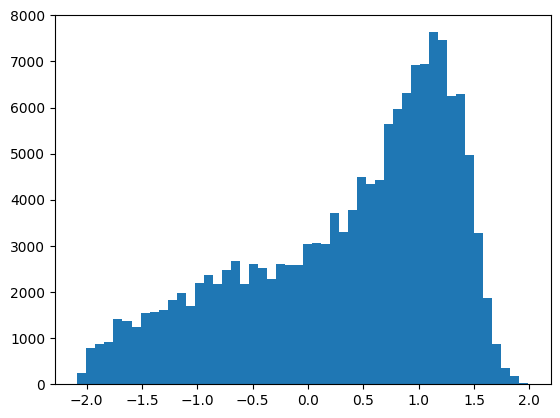

In [21]:
plt.hist(images[5].flatten(), bins=50)
plt.show()                   
#归一化已经把每一个像素都处理了，所以现在的像素都不是0-255的整数，而是一个以0为均值的有负有正的，这样的像素值更容易被神经网络处理。

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'label:3')

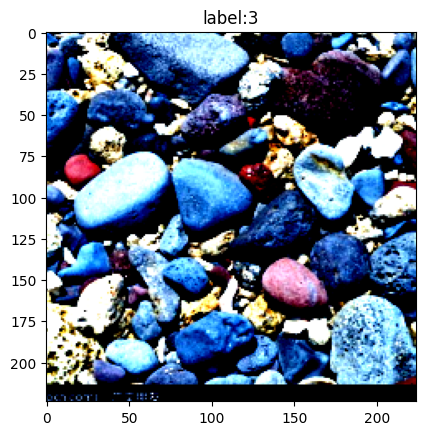

In [22]:
# batch 中经过预处理的图像
idx = 2
plt.imshow(images[idx].transpose((1,2,0))) # 转为(224, 224, 3)
plt.title('label:'+str(labels[idx].item()))

In [23]:
label = labels[idx].item()

In [24]:
label

3

In [25]:
pred_classname = idx_to_labels[label]

In [26]:
pred_classname

'Subrounded'

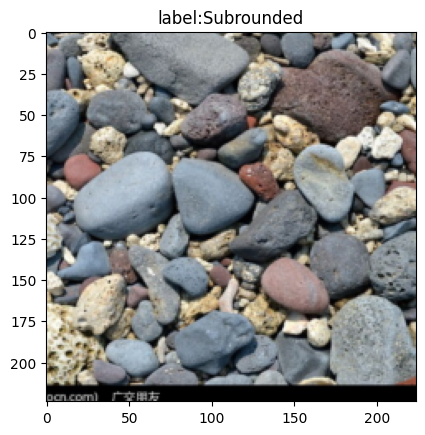

In [27]:
# 原始图像
idx = 2
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
plt.imshow(np.clip(images[idx].transpose((1,2,0)) * std + mean, 0, 1))
plt.title('label:'+ pred_classname)
plt.show()
#这是调取了一个batch的其中一张图像拿出来看看，实际的调试就是一口一口一个batch一个batch喂进去。

### 导入训练需使用的工具包

In [28]:
#多加一个learning rate scheduler学习率的降低，优化策略

In [29]:
from torchvision import models
import torch.optim as optim
from torch.optim import lr_scheduler

In [30]:
#迁移学习的几个方案，取决于自己的数据分布跟ImageNet数据分布的差异。第一种，相当于只换了一下最后的分类层，1000种变成30种这样，只训练换了的30层，其他都冻结

### 选择一：只微调训练模型最后一层（全连接分类层）

In [31]:
model = models.resnet18(pretrained=True) # 载入预训练模型

# 修改全连接层，使得全连接层的输出与当前数据集类别数对应
# 新建的层默认 requires_grad=True
model.fc = nn.Linear(model.fc.in_features, n_class)

In [32]:
model.fc

Linear(in_features=512, out_features=6, bias=True)

In [33]:
# 只微调训练最后一层全连接层的参数，其它层冻结  优化器Adam
optimizer = optim.Adam(model.fc.parameters())

### 选择二：微调训练所有层

In [34]:
#数据集跟ImageNet从分布上不太一样，比如说医疗、结构、轨道伤损这类的、制造业缺陷检测等，可以微调训练所有层（而不是只训练分类层）

In [35]:
#在模型的所有层都进行微调，微调也是以这个预训练模型初始化来调的，也是赢在起跑线上的，仍然可以复用一部分已经训练好的权重和特征。

In [36]:
# model = models.resnet18(pretrained=True) # 载入预训练模型

# model.fc = nn.Linear(model.fc.in_features, n_class)

# optimizer = optim.Adam(model.parameters())

### 选择三：随机初始化模型全部权重，从头训练所有层

In [37]:
#数据集和ImageNet完全不一样，从尺寸、尺度环境等，像显微镜、天文望远镜这种。相当于不管ImageNet了，从头自己调一个Resnet18

In [38]:
# model = models.resnet18(pretrained=False) # 只载入模型结构，不载入预训练权重参数

# model.fc = nn.Linear(model.fc.in_features, n_class)

# optimizer = optim.Adam(model.parameters())

### 训练配置

In [39]:
model = model.to(device)

# 交叉熵损失函数
criterion = nn.CrossEntropyLoss()    #设定交叉熵损失函数

# 训练轮次 Epoch  训练遍历所有数据算一个Epoch，一个Epoch算每个batch都走完了
EPOCHS = 30

# 学习率降低策略  每隔5个batch，学习率降为原来的0.5，
lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

### 函数：在训练集上训练

In [40]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

In [41]:
def train_one_batch(images, labels):
    '''
    运行一个 batch 的训练，返回当前 batch 的训练日志
    '''
    
    # 获得一个 batch 的数据和标注
    images = images.to(device)
    labels = labels.to(device)
    
    outputs = model(images) # 输入模型，执行前向预测
    loss = criterion(outputs, labels) # 计算当前 batch 中，每个样本的平均交叉熵损失函数值
    
    # 优化更新权重
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # 获取当前 batch 的标签类别和预测类别
    _, preds = torch.max(outputs, 1) # 获得当前 batch 所有图像的预测类别
    preds = preds.cpu().numpy()
    loss = loss.detach().cpu().numpy()
    outputs = outputs.detach().cpu().numpy()
    labels = labels.detach().cpu().numpy()
    
    log_train = {}
    log_train['epoch'] = epoch
    log_train['batch'] = batch_idx
    # 计算分类评估指标
    log_train['train_loss'] = loss
    log_train['train_accuracy'] = accuracy_score(labels, preds)
    # log_train['train_precision'] = precision_score(labels, preds, average='macro')
    # log_train['train_recall'] = recall_score(labels, preds, average='macro')
    # log_train['train_f1-score'] = f1_score(labels, preds, average='macro')
    
    return log_train

### 函数：在整个测试集上评估

In [42]:
# 获得一个 batch 的数据和标注
images, labels = next(iter(train_loader))
images = images.to(device)
labels = labels.to(device)

In [43]:
# 输入模型，执行前向预测
outputs = model(images)

In [44]:
# 获得当前 batch 所有图像的预测类别 logit 分数
outputs.shape

torch.Size([20, 6])

In [45]:
# 由 logit，计算当前 batch 中，每个样本的平均交叉熵损失函数值
loss = criterion(outputs, labels)

In [46]:
#loss

In [47]:
# 反向传播“三部曲”    优化器梯度清零，反向传播求梯度，求得模型的权重该怎么微调能够使得损失函数最小化，接下来再去拧每一个水龙头，拧模型中的每一个权重，
#再按照之前规定的优化器，优化更新每一个权重
optimizer.zero_grad() # 清除梯度
loss.backward() # 反向传播
optimizer.step() # 优化更新

In [48]:
# 获得当前 batch 所有图像的预测类别  看最高置信度的几类
_, preds = torch.max(outputs, 1)

In [49]:
preds

tensor([5, 5, 2, 0, 4, 0, 2, 0, 1, 4, 3, 3, 0, 5, 0, 2, 0, 3, 5, 2],
       device='cuda:0')

In [50]:
labels

tensor([3, 3, 3, 3, 2, 0, 3, 4, 2, 2, 2, 3, 3, 0, 2, 1, 0, 0, 4, 5],
       device='cuda:0')

In [51]:
# 遍历每个 EPOCH
for epoch in tqdm(range(EPOCHS)):

    model.train()

    for images, labels in train_loader:  # 获取训练集的一个 batch，包含数据和标注
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)           # 前向预测，获得当前 batch 的预测结果
        loss = criterion(outputs, labels) # 比较预测结果和标注，计算当前 batch 的交叉熵损失函数
        
        optimizer.zero_grad()
        loss.backward()                   # 损失函数对神经网络权重反向传播求梯度
        optimizer.step()                  # 优化更新神经网络权重

100%|██████████| 30/30 [01:45<00:00,  3.52s/it]


In [52]:
model.eval()                                #model又train改成eval
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in tqdm(test_loader): # 获取测试集的一个 batch，包含数据和标注
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)              # 前向预测，获得当前 batch 的预测置信度
        _, preds = torch.max(outputs, 1)     # 获得最大置信度对应的类别，作为预测结果
        total += labels.size(0)
        correct += (preds == labels).sum()   # 预测正确样本个数

    print('测试集上的准确率为 {:.3f} %'.format(100 * correct / total))

100%|██████████| 13/13 [00:01<00:00,  6.97it/s]

测试集上的准确率为 45.968 %


In [53]:
#比原本多了更多的评估指标
def evaluate_testset():
    '''
    在整个测试集上评估，返回分类评估指标日志
    '''

    loss_list = []
    labels_list = []
    preds_list = []
    
    with torch.no_grad():
        for images, labels in test_loader: # 生成一个 batch 的数据和标注
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images) # 输入模型，执行前向预测

            # 获取整个测试集的标签类别和预测类别
            _, preds = torch.max(outputs, 1) # 获得当前 batch 所有图像的预测类别
            preds = preds.cpu().numpy()
            loss = criterion(outputs, labels) # 由 logit，计算当前 batch 中，每个样本的平均交叉熵损失函数值
            loss = loss.detach().cpu().numpy()
            outputs = outputs.detach().cpu().numpy()
            labels = labels.detach().cpu().numpy()

            loss_list.append(loss)
            labels_list.extend(labels)
            preds_list.extend(preds)
        
    log_test = {}
    log_test['epoch'] = epoch
    
    # 计算分类评估指标
    log_test['test_loss'] = np.mean(loss_list)
    log_test['test_accuracy'] = accuracy_score(labels_list, preds_list)
    log_test['test_precision'] = precision_score(labels_list, preds_list, average='macro')
    log_test['test_recall'] = recall_score(labels_list, preds_list, average='macro')
    log_test['test_f1-score'] = f1_score(labels_list, preds_list, average='macro')
    
    return log_test

### 训练开始之前，记录日志

In [54]:
epoch = 0
batch_idx = 0
best_test_accuracy = 0

In [55]:
# 训练日志-训练集
df_train_log = pd.DataFrame()
log_train = {}
log_train['epoch'] = 0
log_train['batch'] = 0
images, labels = next(iter(train_loader))
log_train.update(train_one_batch(images, labels))
df_train_log = df_train_log._append(log_train, ignore_index=True)

In [56]:
df_train_log

,epoch,batch,train_loss,train_accuracy
0,0,0,0.7072705,0.8


In [57]:
# 训练日志-测试集
df_test_log = pd.DataFrame()
log_test = {}
log_test['epoch'] = 0
log_test.update(evaluate_testset())
df_test_log = df_test_log._append(log_test, ignore_index=True)

In [58]:
df_test_log

,epoch,test_loss,test_accuracy,test_precision,test_recall,test_f1-score
0,0.0,1.38449,0.471774,0.467914,0.469487,0.465256


### 创建wandb可视化项目

In [59]:
import wandb

wandb.init(project='Particle Figures', name=time.strftime('%m%d%H%M%S'))

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: harrisyaohua (stay_hungry). Use `wandb login --relogin` to force relogin


### 运行训练

In [60]:
for epoch in range(1, EPOCHS+1):
    
    print(f'Epoch {epoch}/{EPOCHS}')
    
    ## 训练阶段
    model.train()
    for images, labels in tqdm(train_loader): # 获得一个 batch 的数据和标注
        batch_idx += 1
        log_train = train_one_batch(images, labels)
        df_train_log = df_train_log._append(log_train, ignore_index=True)
        wandb.log(log_train)
        
    lr_scheduler.step()

    ## 测试阶段
    model.eval()
    log_test = evaluate_testset()
    df_test_log = df_test_log._append(log_test, ignore_index=True)
    wandb.log(log_test)
    
    # 保存最新的最佳模型文件
    if log_test['test_accuracy'] > best_test_accuracy: 
        # 删除旧的最佳模型文件(如有)
        old_best_checkpoint_path = 'checkpoint/best-{:.3f}.pth'.format(best_test_accuracy)
        if os.path.exists(old_best_checkpoint_path):
            os.remove(old_best_checkpoint_path)
        # 保存新的最佳模型文件
        best_test_accuracy = log_test['test_accuracy']
        new_best_checkpoint_path = 'checkpoint/best-{:.3f}.pth'.format(log_test['test_accuracy'])
        torch.save(model, new_best_checkpoint_path)
        print('保存新的最佳模型', 'checkpoint/best-{:.3f}.pth'.format(best_test_accuracy))
        # best_test_accuracy = log_test['test_accuracy']

df_train_log.to_csv('训练日志-训练集.csv', index=False)
df_test_log.to_csv('训练日志-测试集.csv', index=False)

Epoch 1/30


100%|██████████| 50/50 [00:03<00:00, 14.07it/s]


保存新的最佳模型 checkpoint/best-0.480.pth
Epoch 2/30


100%|██████████| 50/50 [00:03<00:00, 13.87it/s]


Epoch 3/30


100%|██████████| 50/50 [00:03<00:00, 14.89it/s]


Epoch 4/30


100%|██████████| 50/50 [00:03<00:00, 14.63it/s]


Epoch 5/30


100%|██████████| 50/50 [00:03<00:00, 14.89it/s]


Epoch 6/30


100%|██████████| 50/50 [00:03<00:00, 13.27it/s]


Epoch 7/30


100%|██████████| 50/50 [00:03<00:00, 13.10it/s]


Epoch 8/30


100%|██████████| 50/50 [00:03<00:00, 14.43it/s]


保存新的最佳模型 checkpoint/best-0.484.pth
Epoch 9/30


100%|██████████| 50/50 [00:03<00:00, 12.96it/s]


Epoch 10/30


100%|██████████| 50/50 [00:03<00:00, 13.77it/s]


Epoch 11/30


100%|██████████| 50/50 [00:03<00:00, 14.31it/s]


保存新的最佳模型 checkpoint/best-0.488.pth
Epoch 12/30


100%|██████████| 50/50 [00:03<00:00, 14.33it/s]


Epoch 13/30


100%|██████████| 50/50 [00:03<00:00, 14.24it/s]


Epoch 14/30


100%|██████████| 50/50 [00:03<00:00, 14.90it/s]


Epoch 15/30


100%|██████████| 50/50 [00:03<00:00, 13.64it/s]


保存新的最佳模型 checkpoint/best-0.492.pth
Epoch 16/30


100%|██████████| 50/50 [00:03<00:00, 13.80it/s]


Epoch 17/30


100%|██████████| 50/50 [00:03<00:00, 13.91it/s]


Epoch 18/30


100%|██████████| 50/50 [00:03<00:00, 13.98it/s]


Epoch 19/30


100%|██████████| 50/50 [00:03<00:00, 13.10it/s]


保存新的最佳模型 checkpoint/best-0.496.pth
Epoch 20/30


100%|██████████| 50/50 [00:03<00:00, 13.07it/s]


Epoch 21/30


100%|██████████| 50/50 [00:03<00:00, 12.99it/s]


Epoch 22/30


100%|██████████| 50/50 [00:03<00:00, 13.58it/s]


Epoch 23/30


100%|██████████| 50/50 [00:03<00:00, 14.17it/s]


Epoch 24/30


100%|██████████| 50/50 [00:03<00:00, 14.31it/s]


Epoch 25/30


100%|██████████| 50/50 [00:03<00:00, 14.31it/s]


Epoch 26/30


100%|██████████| 50/50 [00:04<00:00, 12.40it/s]


Epoch 27/30


100%|██████████| 50/50 [00:03<00:00, 13.85it/s]


Epoch 28/30


100%|██████████| 50/50 [00:03<00:00, 13.94it/s]


Epoch 29/30


100%|██████████| 50/50 [00:03<00:00, 13.79it/s]


Epoch 30/30


100%|██████████| 50/50 [00:03<00:00, 13.48it/s]


### 在测试集上评价

In [61]:
# 载入最佳模型作为当前模型
model = torch.load('checkpoint/best-{:.3f}.pth'.format(best_test_accuracy))

In [62]:
model.eval()
print(evaluate_testset())

{'epoch': 30, 'test_loss': 1.3730208, 'test_accuracy': 0.4959677419354839, 'test_precision': 0.49196107255317784, 'test_recall': 0.45756764305151404, 'test_f1-score': 0.4639919864130768}
